In [8]:
import os
import sys
import random

import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageDraw, ImageSequence
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import to_tensor, to_pil_image

sys.path.append(r'/home/declan/Documents/Projects/CS639-FinalProject/src/reconstruction/')
from dataset import FaceDataset
from policy import Policy
from utils import StateObject

In [9]:
def plot_views(images, decoded_all, visited_idxes, filename):
    n_views = len(decoded_all)
    n_imgs = decoded_all[0].shape[0]
    i_img = random.randint(1, n_imgs-1)
    orig_img = to_pil_image(images[i_img])
    dec_img = to_pil_image(decoded_all[-1][i_img].detach().cpu())
    visited_idxes = visited_idxes[i_img, 1:]
    imgs = np.dstack([idxes[i_img].reshape([16, 16]) for idxes in visited_idxes])
    heat_map = np.sum(imgs, axis=2, dtype=int)
    heat_map = heat_map.repeat(32, axis=0).repeat(32, axis=1) # upsample to (512 x 512)
    heat_map_mask = np.logical_not(np.dstack([heat_map, heat_map, heat_map]))
    heat_map = np.dstack([np.zeros([512, 512], dtype=int), heat_map, np.zeros([512, 512], dtype=int)]) # make green squares.
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    img_with_heat_map = np.asarray(orig_img)*heat_map_mask+heat_map*255
    decoded_img = np.asarray(dec_img)
    axes[0].imshow(img_with_heat_map.astype(np.uint8))
    axes[1].imshow(decoded_img.astype(np.uint8))
    axes[0].axis('off')
    axes[1].axis('off')
    plt.tight_layout()
    plt.savefig(filename)

In [10]:
def create_view_gif(decoded_all, images, visited_idxes, gifname):
    
    # Draws a square on the given image.
    def draw_square_from_idx(img, idx):
        i = idx % 16
        j = idx // 16
        x1 = i*32
        x2 = (i+1)*32-1
        y1 = j*32
        y2 = (j+1)*32-1
        draw = ImageDraw.Draw(img, mode='RGB')
        draw.rectangle(((x1, y1), (x2, y2)), fill=(0, 255, 0))
        return img
    
    n_views = len(decoded_all)
    n_imgs = decoded_all[0].shape[0]
    i_img = random.randint(0, n_imgs-1)
    orig_img = to_pil_image(images[i_img])
    padding = (10, 10, 10, 10)
    # New img.
    total_width = 1024+40
    max_height = 512+20
    final_imgs = [] # Stores list of concatenated images.
    for i_view in range(-1, n_views): #### CHANGE THIS LATER.
        new_img = Image.new('RGB', (total_width, max_height)) # Concatenated image.
        # First add a blank image.
        if i_view == -1:
            orig_img_padded = ImageOps.expand(orig_img.copy(), padding, fill=(255,255,255))
            blank_img = Image.new('RGB', (532, 532)) #, fill=(255,255,255))
            new_img.paste(orig_img_padded, (0, 0))
            new_img.paste(blank_img, (542, 0))
            final_imgs.append(new_img)
            continue
        # idx is always (0,0) if first i_view.
        elif i_view == 0:
            idx = 0
        # Otherwise, the get the idx of the max view.
        else:
            idx = np.argmax(visited_idxes[i_view][i_img])
        # Draw the image.
        dec_img = to_pil_image(decoded_all[i_view][i_img].detach().cpu())
        orig_img = draw_square_from_idx(orig_img, idx)
        orig_img_padded = ImageOps.expand(orig_img.copy(), padding, fill=(255,255,255))
        dec_img_padded = ImageOps.expand(dec_img.copy(), padding, fill=(255,255,255))
        new_img.paste(orig_img_padded, (0, 0))
        new_img.paste(dec_img_padded, (542, 0))
        final_imgs.append(new_img)
    final_imgs[0].save(gifname, save_all=True, append_images=final_imgs[1:], duration=500, loop=0)

In [11]:
class Agent():
    """
    This agent implements the policy from Policy class and uses REINFORCE / Actor-Critic for policy improvement
    """
    def __init__(self):
        super(Agent, self).__init__()
        self.policy = Policy().to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=1e-4)
        self.iscuda = True
        
        # Maybe not necessary.
        self.R_avg = 0
        self.avg_count = 0
        self.reward_scale = 1
        self.lambda_entropy = 1e-1
        self.selection_type = 'notgreedy'


    def gather_trajectory(self, state_object):
        """
        gather_trajectory gets an observation, updates it's belief of the state, decodes the
        panorama and takes the next action. This is done repeatedly for T time steps.
        Note:
        eval_opts are provided only during testing
        """

        # Setup variables to store trajectory information.
        self.T = 10
        rewards = []
        log_probs = []
        rec_errs = []
        actions = []
        entropies = []
        self.avg_count = 0
        hidden = None
        visited_idxes = []
        batch_size = state_object.batch_size
        decoded_all = []
        actions_taken = torch.zeros([batch_size, self.T-1])
        action_probs = None
        acts= None
        
        # NOTE: EXPERIMENTAL.
        views = torch.zeros([batch_size, 256], requires_grad=False, dtype=int).to(device)
        
        for t in range(self.T):
            #print('Iteration ', str(t))
            # ---- Observe the panorama ----
            # At first iteration, action probs==None, so state_object returns a fixed view at (0,0).
            im, pro = state_object.get_view(acts) #action_probs) ##### THIS IS A TEST. ######
            im, pro = torch.Tensor(im), torch.Tensor(pro)
            
            # Keep track of visited locations
            visited_idxes.append(state_object.index)

            # ---- Policy forward pass ----
            policy_input = {'im': im, 'pro': pro}
            
            # Update if using CUDA.
            if self.iscuda:
                for var in policy_input:
                    policy_input[var] = policy_input[var].cuda()
            
            # Otherwise use the CPU.
            else:
                for var in policy_input:
                    policy_input[var] = Variable(policy_input[var])

            # Note: decoded and hidden correspond to the previous transition
            # probs and value correspond to the new transition, where the value
            # and action probabilities of the current state are estimated for PG update.
            action_probs, hidden, decoded = self.policy.forward(policy_input, views.clone().type(torch.float32), hidden=hidden)
            decoded_all.append(decoded)

            # Compute reconstruction loss (corresponding to the previous transition).
            rec_err = F.mse_loss(decoded, state_object.images.to(device))
            self.optimizer.zero_grad()
            nn.utils.clip_grad_norm_(self.policy.parameters(), 10)
            rec_err.backward(retain_graph=True)
            self.optimizer.step()
            
            # Gradient ascent.
            if t>=1:
                diff = -(rec_err-rec_errs[t-1])
                probs = action_probs.clone().detach() #actions_probs_list[t-1] # action probs for previous timestep.
                # diff is positive if we improved, so add it to the associated action_prob to reinforce that action.
                probs[range(acts.size(0)), acts[:, 0]] = probs[range(acts.size(0)), acts[:, 0]] + diff.detach()*.01 # So it doesn't choose a single action too strongly...
                
                # NOTE: THIS IS EXPERIMENTATAL.
                probs[views] = 0
                
                act_err = F.mse_loss(action_probs, probs)
                self.optimizer.zero_grad()
                if t<self.T:
                    act_err.backward(retain_graph=True) ####### NOTE: GRAPH RETAINED WHEN USING update_policy.
                else:
                    act_err.backward()
                self.optimizer.step()


            # Reconstruction reward is obtained only at the final step
            # If there is only one step (T=1), then do not provide rewards
            # Note: This reward corresponds to the previous action
            if t == 0:
                reward = torch.zeros(batch_size)
                if self.iscuda:
                    reward = reward.cuda()
            else:
                reward = -rec_err.data # Disconnects reward from future updates
                self.R_avg = (self.R_avg * self.avg_count + reward.sum())/(self.avg_count + batch_size)
                self.avg_count += batch_size
            if t > 0:
                rewards[t-1] += reward
                
            # There are self.T reconstruction errors as opposed to self.T-1 rewards
            rec_errs.append(rec_err)

            # Sample action except for the last time step when only the selected view from previous step is used in aggregate.
            if t < self.T - 1:
                # Act based on the policy network
                if self.selection_type != 'greedy':
                    acts = action_probs.multinomial(num_samples=1).data
                else:
                    # This works only while evaluating, not while training
                    _, acts = action_probs.max(dim=1)
                    acts = acts.data.view(-1, 1)
                
                # Compute entropy
                entropy = -(action_probs*((action_probs+1e-7).log())).sum(dim=1)
                # Store log probabilities of selected actions (Advanced indexing).
                log_prob = (action_probs[range(acts.size(0)), acts[:, 0]]+1e-7).log() # Save log_probs of choosing selected actions.

                # This is the intrinsic reward corresponding to the current action
                actions.append(acts)
                rewards.append(reward)
                log_probs.append(log_prob)
                entropies.append(entropy)

        return log_probs, rec_errs, rewards, entropies, decoded, visited_idxes, decoded_all, actions_taken
    
    
    def update_policy(self, rewards, log_probs, entropies, task_errs=None, values=None):
        batch_size = rewards[0].size(0)
        R = torch.zeros(batch_size) # Reward accumulator
        loss = Variable(torch.Tensor([0]))
        if self.iscuda:
            loss = loss.cuda()
            R = R.cuda()
    
        # REINFORCE loss based on T-1 transitions.
        for t in reversed(range(self.T-1)):
            R = R + rewards[t]
            # PG loss
            loss_term_1 = -(log_probs[t]*self.reward_scale).sum()/batch_size
            # Entropy loss, maximize entropy
            loss_term_2 = -self.lambda_entropy*entropies[t].sum()/batch_size
            loss = loss + loss_term_1 + loss_term_2
    
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.policy.parameters(), 10)
        self.optimizer.step()

____________
___________

### New training setup.

In [5]:
def generate_train_test_dfs(train_ratio):
    attribute_file = 'CelebAMask-HQ-attribute-anno.txt'
    datadir = '/home/declan/Data/Faces/'
    img_dir = os.path.join(datadir, 'CelebA-HQ-img')
    attr_dir = os.path.join(datadir, 'CelebAMask-HQ-attribute-anno.txt')
    attributes = pd.read_csv(attr_dir, delimiter=' ')
    good_data = attributes[['Bald', 'Smiling', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necktie', 'Wearing_Necklace', 'Gray_Hair', 'Eyeglasses']]
    good_data = good_data.clip(lower=0) # Set -1 to 0.
    good_data = good_data[(good_data.T != 0).any()] # drop any rows with only zeros.
    good_data = good_data.sample(frac=1) # Shuffle dataframe.
    n_train_imgs = int(good_data.shape[0]*train_ratio)
    train_data = good_data.iloc[:n_train_imgs, :]
    test_data = good_data.iloc[n_train_imgs:, :]
    return train_data, test_data

In [6]:
def evaluate(policy, state_object):
    """
    gather_trajectory gets an observation, updates it's belief of the state, decodes the
    panorama and takes the next action. This is done repeatedly for T time steps.
    Note:
    eval_opts are provided only during testing
    """

    # Setup variables to store trajectory information.
    iscuda=True
    T = 10
    rec_errs = []
    visited_idxes = []
    batch_size = state_object.batch_size
    decoded_all = []
    hidden = None
    acts = None
    
    # NOTE: EXPERIMENTAL.
    views = torch.zeros([batch_size, 256]).to(device)
    
    for t in range(T):
        # At first iteration, action probs==None, so state_object returns a fixed view at (0,0).
        im, pro = state_object.get_view(acts) #action_probs)
        im, pro = torch.Tensor(im), torch.Tensor(pro)
        visited_idxes.append(state_object.index)
        policy_input = {'im': im, 'pro': pro}
        
        # Update if using CUDA.
        if iscuda:
            for var in policy_input:
                policy_input[var] = policy_input[var].cuda()
        
        # Otherwise use the CPU.
        for var in policy_input:
            policy_input[var] = Variable(policy_input[var])
            
        action_probs, hidden, decoded = policy.forward(policy_input, views.clone().type(torch.float32), hidden=hidden)
        rec_err = F.mse_loss(decoded, state_object.images.to(device))
        rec_errs.append(rec_err)
        decoded_all.append(decoded)
        
        _, acts = action_probs.max(dim=1)
        acts = acts.data.view(-1, 1)
        
        # NOTE: THIS NEXT LINE IS EXPERIMENTAL.
        if t>0:
            views[range(acts.size(0)), acts[:, 0]] = 1
        
    return rec_errs, visited_idxes, decoded_all

In [7]:
def train(agent, dataloader, epoch):
    epoch_total_loss = 0.0
    agent.policy.train()
    for batch_idx, data in enumerate(dataloader):
        images, _ = data
        state_object = StateObject(images)
        if images.shape[0] != 32:
            continue
        log_probs, rec_errs, rewards, entropies, decoded, visited_idxes, decoded_all, _ = agent.gather_trajectory(state_object)
        #agent.update_policy(rewards, log_probs, entropies)
        rec_errs = [err.cpu().detach().numpy() for err in rec_errs] # Always detach variables from the graph :()
        loss = sum(rec_errs)/len(rec_errs)
        epoch_total_loss = epoch_total_loss + loss
    print('Epoch {} Train Loss: {:.4f}'.format(epoch, epoch_total_loss))

In [8]:
def test(policy, dataloader, epoch):
    epoch_total_loss = 0.0
    policy.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader):
            images, _ = data
            state_object = StateObject(images)
            if images.shape[0] != 32:
                continue
            rec_errs, visited_idxes, decoded_all = evaluate(policy, state_object)
            
            # Update loss tracker.
            rec_errs = [err.cpu().detach().numpy() for err in rec_errs] # Always detach variables from the graph :()
            loss = sum(rec_errs)/len(rec_errs)
            epoch_total_loss = epoch_total_loss + loss
            
            # Only save one example at the end of the epoch.
            if batch_idx%50 == 0:
                gifname = './Output/E'+str(epoch)+'B'+str(batch_idx)+'.gif'
                figname = './Output/E'+str(epoch)+'B'+str(batch_idx)+'.svg'
                create_view_gif(decoded_all, images, visited_idxes, gifname)
                plot_views(images, decoded_all, visited_idxes, figname)
        print('Epoch {} Test Loss: {:.4f}'.format(epoch, epoch_total_loss))

Epoch 0 Train Loss: 34.8630
Epoch 0 Test Loss: 10.1888
Epoch 1 Train Loss: 32.2901
Epoch 1 Test Loss: 8.9886
Epoch 2 Train Loss: 31.8616
Epoch 2 Test Loss: 8.7198
Epoch 3 Train Loss: 31.5650
Epoch 3 Test Loss: 8.7321
Epoch 4 Train Loss: 31.2161
Epoch 4 Test Loss: 8.7976
Epoch 5 Train Loss: 30.6697


/home/declan/miniconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


Epoch 5 Test Loss: 8.5629
Epoch 6 Train Loss: 30.2168
Epoch 6 Test Loss: 8.6469
Epoch 7 Train Loss: 29.8948
Epoch 7 Test Loss: 8.5180
Epoch 8 Train Loss: 29.6906
Epoch 8 Test Loss: 8.6381
Epoch 9 Train Loss: 29.4529
Epoch 9 Test Loss: 8.5571
Epoch 10 Train Loss: 29.2255
Epoch 10 Test Loss: 8.5764
Epoch 11 Train Loss: 29.1053
Epoch 11 Test Loss: 8.3245
Epoch 12 Train Loss: 28.9016
Epoch 12 Test Loss: 8.5111
Epoch 13 Train Loss: 28.8898
Epoch 13 Test Loss: 8.6493
Epoch 14 Train Loss: 28.7775
Epoch 14 Test Loss: 8.4564
Epoch 15 Train Loss: 28.6621
Epoch 15 Test Loss: 8.5435
Epoch 16 Train Loss: 28.5542
Epoch 16 Test Loss: 8.5195
Epoch 17 Train Loss: 28.4670
Epoch 17 Test Loss: 8.5803
Epoch 18 Train Loss: 28.3632
Epoch 18 Test Loss: 8.5226


KeyboardInterrupt: 

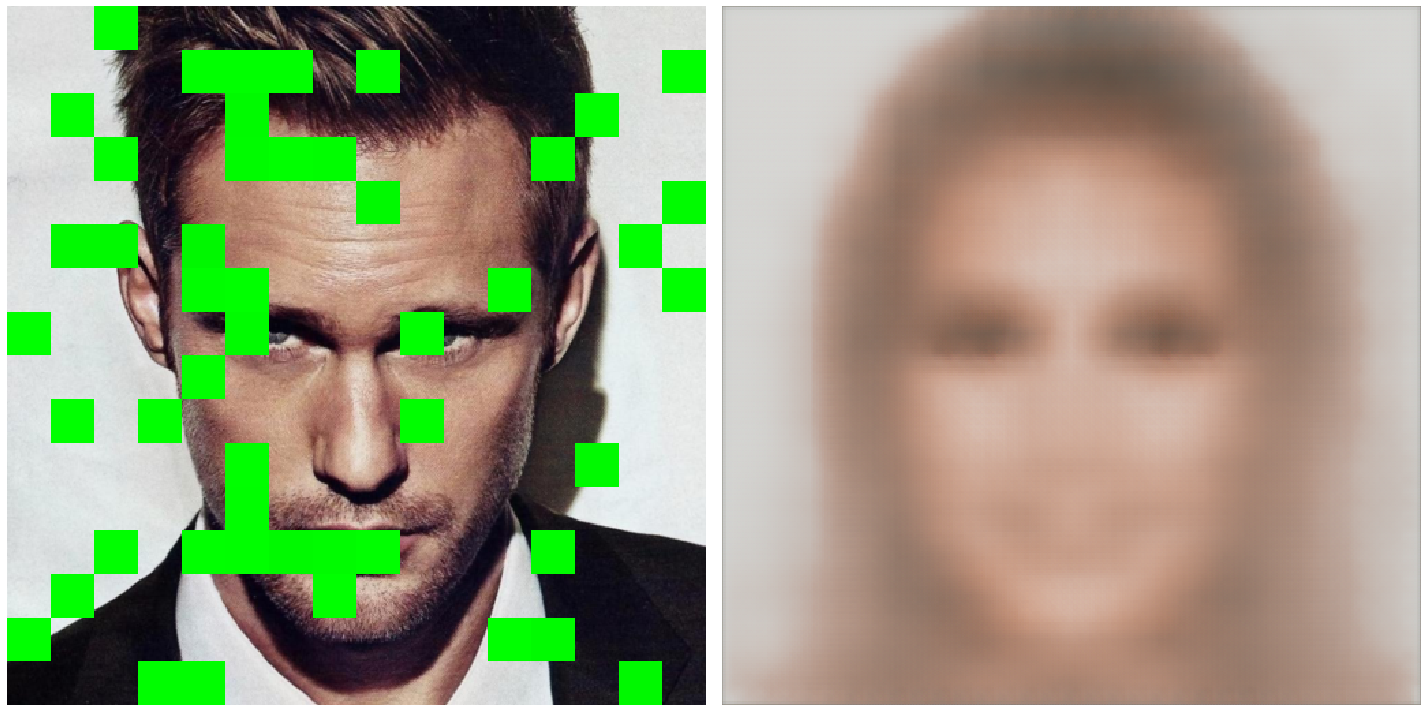

Error in callback <function flush_figures at 0x7f0cec291f80> (for post_execute):


KeyboardInterrupt: 

In [9]:
device = 'cuda'
torch.backends.cudnn.benchmark = True
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 8}

# Set up the Datasets and the DataLoaders.
train_data, test_data = generate_train_test_dfs(.8)
transforms_ = transforms.Compose([transforms.Resize(size=(512, 512)) , transforms.ToTensor()])
train_dataset = FaceDataset(train_data, transforms=transforms_)
test_dataset = FaceDataset(test_data, transforms=transforms_)
train_loader = DataLoader(train_dataset, **params)
test_loader = DataLoader(test_dataset, **params)

# Set up the model and the optimizer.
agent = Agent()
#state_dict = torch.load('../model_all_upd.pkl', map_location='cpu')
#agent.policy.load_state_dict(state_dict['model_state_dict'])

# Begin training model.
n_epochs = 250
for epoch in range(n_epochs):

    # Train the agent.
    train(agent, train_loader, epoch)
        
    # Test the agent.
    test(agent.policy, test_loader, epoch)

In [ ]:
torch.save({'epoch': epoch,
            'model_state_dict': agent.policy.state_dict(),
            'loss': loss}, '/home/declan/Documents/Projects/CS639-FinalProject/model_all_upd.pkl')